# Прогнозирование оттока  и кластеризация пользователей телекоммуникационной компании
подготовил: [Владимир Сизов](mailto:vladimirsizov@yandex.ru)  

<hr>
Мы работаем с датасетом клиентов телекоммуникационной компании TELCO.  
Необходимо определить показатели и возможные причины оттока пользователей.

Для выявления характеристик пользователей склонных к оттоку мы будем использовать библиотеки логистической регрессии и случайный лес.  Подготовим данные, определим какая модель обладает лучшими показателями предсказания, а также попробуем применить нормализацию данных для улучшения показателей.  
Также нам необходимо кластеризовать пользователей и сравнить их характеристики.

данные:  
customerID = id пользователя  
gender - пол (Male, Female)  
SeniorCitizen — является ли клиент пожилым гражданином или нет (1, 0)  
Partner — есть ли у клиента партнер или нет (Yes, No)  
Dependents - есть ли у клиента иждивенцы или нет (Yes, No)  
tenure - Количество месяцев, в течение которых клиент оставался в компании  
PhoneService — есть ли у клиента телефонная служба или нет (Yes, No)  
MultipleLines — есть ли у клиента несколько линий или нет (Yes, No, No phone service)  
InternetService - интернет-провайдер клиента (DSL, Fiber optic, No)  
OnlineSecurity — есть ли у клиента онлайн-защита или нет (Yes, No, No internet service)  
OnlineBackup — есть ли у клиента онлайн-резервное копирование или нет (Yes, No, No internet service)  
DeviceProtection — есть ли у клиента защита устройства или нет (Yes, No, No internet service)  
TechSupport — есть ли у клиента техническая поддержка или нет (Yes, No, No internet service)  
StreamingTV — есть ли у клиента потоковое телевидение или нет (Yes, No, No internet service)  
StreamingMovies — есть ли у клиента потоковые фильмы или нет (Yes, No, No internet service)  
Contract - Срок контракта клиента (Month-to-month, One year, Two year)  
PaperlessBilling — есть ли у клиента безбумажный биллинг или нет (Yes, No)  
PaymentMethod — способ оплаты клиента   
    (электронный чек, чек по почте, банковский перевод (автоматический), кредитная карта (автоматический))  
    (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))  
MonthlyCharges — сумма, взимаемая с клиента ежемесячно  
TotalCharges — общая сумма, списанная с клиента  
Churn — ушёл ли клиент или нет (Yes or No)  

<hr>

## EDA и предобработка данных

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

In [2]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
# это лишнее
data = df.drop(columns=['customerID'])

In [4]:
# взглянем на структуру данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [5]:
# нужно привести колонку TotalCharges к числовому формату
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors="coerce")

In [6]:
# проверим пропуски
data.isna().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [7]:
# удалим 11 строк с пропусками
data.dropna(inplace=True)

In [8]:
# проверяем есть ли противоречие в данных между колонками PhoneService и MultipleLines
True if len(data[(data.PhoneService == 'No') & (data.MultipleLines != 'No phone service')]) > 0 else False

False

In [9]:
# проверяем есть ли противоречие в данных между колонками InternetService и 
# (OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies)

True if len(data[(data.InternetService == 'No') &
     ((data.OnlineSecurity != 'No internet service') |
     (data.OnlineBackup != 'No internet service') |
     (data.DeviceProtection != 'No internet service') |
     (data.TechSupport != 'No internet service') |
     (data.StreamingTV != 'No internet service') |
     (data.StreamingMovies != 'No internet service'))]) > 0 else False

False

In [10]:
# у нас есть столбцы которые можно перевести в бинарное значение
for i in data.columns.tolist(): 
    if len(data[i].unique().tolist()) < 3:
        print(i, data[i].unique().tolist())

gender ['Female', 'Male']
SeniorCitizen [0, 1]
Partner ['Yes', 'No']
Dependents ['No', 'Yes']
PhoneService ['No', 'Yes']
PaperlessBilling ['Yes', 'No']
Churn ['No', 'Yes']


In [11]:
# делаем признаки бинарными
data['gender'] = data['gender'].replace(['Male', 'Female'], [1, 0])
data['Partner'] = data['Partner'].replace(['Yes', 'No'], [1, 0])
data['Dependents'] = data['Dependents'].replace(['Yes', 'No'], [1, 0])
data['PhoneService'] = data['PhoneService'].replace(['Yes', 'No'], [1, 0])
data['PaperlessBilling'] = data['PaperlessBilling'].replace(['Yes', 'No'], [1, 0])
data['Churn'] = data['Churn'].replace(['Yes', 'No'], [1, 0])

In [12]:
# посмотрим на оставшиеся категориальные переменные
for i in data.columns.tolist(): 
    if 2 < len(data[i].unique().tolist()) < 10 :
        print(i, data[i].unique().tolist())

MultipleLines ['No phone service', 'No', 'Yes']
InternetService ['DSL', 'Fiber optic', 'No']
OnlineSecurity ['No', 'Yes', 'No internet service']
OnlineBackup ['Yes', 'No', 'No internet service']
DeviceProtection ['No', 'Yes', 'No internet service']
TechSupport ['No', 'Yes', 'No internet service']
StreamingTV ['No', 'Yes', 'No internet service']
StreamingMovies ['No', 'Yes', 'No internet service']
Contract ['Month-to-month', 'One year', 'Two year']
PaymentMethod ['Electronic check', 'Mailed check', 'Bank transfer (automatic)', 'Credit card (automatic)']


Имеются данные которые можно разделить на две группы:

Данные которые можно поделить (есть_услуга/нет_услуги и удалить сервис_не_подключен так как эта информация есть в InternetService или PhoneService) во избежани полной мултиколлинеарности:  
OnlineSecurity — есть ли у клиента онлайн-защита или нет (Yes, No, No internet service)    
OnlineBackup — есть ли у клиента онлайн-резервное копирование или нет (Yes, No, No internet service)  
DeviceProtection — есть ли у клиента защита устройства или нет (Yes, No, No internet service)  
TechSupport — есть ли у клиента техническая поддержка или нет (Yes, No, No internet service)  
StreamingTV — есть ли у клиента потоковое телевидение или нет (Yes, No, No internet service)  
StreamingMovies — есть ли у клиента потоковые фильмы или нет (Yes, No, No internet service)  
MultipleLines — есть ли у клиента несколько линий или нет (Yes, No, No phone service) 

Данные которые можно поделить (услуга_A/услуга_B/...): 
InternetService - интернет-провайдер клиента (DSL, Fiber optic, No)   
Contract - Срок контракта клиента (Month-to-month, One year, Two year)   
PaymentMethod — способ оплаты клиента(Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic)) 

In [13]:
# приведёмв dummy категориальные переменные
data = pd.get_dummies(data)

In [14]:
# удалим колонки для улучшения модели
data = data.drop(columns=['MultipleLines_No phone service', 'OnlineSecurity_No internet service',
                          'OnlineBackup_No internet service', 'DeviceProtection_No internet service',
                          'TechSupport_No internet service', 'StreamingTV_No internet service',
                          'StreamingMovies_No internet service', 'MultipleLines_No', 'InternetService_No',
                          'TechSupport_No','OnlineSecurity_No', 'OnlineBackup_No', 'DeviceProtection_No',
                          'StreamingTV_No', 'StreamingMovies_No'])

In [15]:
# переименуем колонки в более корректную форму
data = data.rename(columns={'PaymentMethod_Bank transfer (automatic)': 'PaymentMethod_Bank_transfer_automatic',
                    'PaymentMethod_Credit card (automatic)': 'PaymentMethod_Credit_card_automatic',
                    'PaymentMethod_Electronic check': 'PaymentMethod_Electronic_check',
                    'PaymentMethod_Mailed check': 'PaymentMethod_Mailed_check',
                    'InternetService_Fiber optic': 'InternetService_Fiber_optic',
                    'Contract_One year': 'Contract_One_year', 'Contract_Two year': 'Contract_Two_year',
                    'MultipleLines_Yes': 'MultipleLines', 'OnlineSecurity_Yes': 'OnlineSecurity',
                    'OnlineBackup_Yes': 'OnlineBackup', 'DeviceProtection_Yes': 'DeviceProtection',
                    'TechSupport_Yes': 'TechSupport', 'StreamingTV_Yes': 'StreamingTV',
                    'StreamingMovies_Yes': 'StreamingMovies', 'Contract_Month-to-month': 'Contract_Month_to_month'})

In [16]:
data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,TechSupport,StreamingTV,StreamingMovies,Contract_Month_to_month,Contract_One_year,Contract_Two_year,PaymentMethod_Bank_transfer_automatic,PaymentMethod_Credit_card_automatic,PaymentMethod_Electronic_check,PaymentMethod_Mailed_check
0,0,0,1,0,1,0,1,29.85,29.85,0,...,0,0,0,1,0,0,0,0,1,0
1,1,0,0,0,34,1,0,56.95,1889.50,0,...,0,0,0,0,1,0,0,0,0,1
2,1,0,0,0,2,1,1,53.85,108.15,1,...,0,0,0,1,0,0,0,0,0,1
3,1,0,0,0,45,0,0,42.30,1840.75,0,...,1,0,0,0,1,0,1,0,0,0
4,0,0,0,0,2,1,1,70.70,151.65,1,...,0,0,0,1,0,0,0,0,1,0


In [17]:
# посмотрим как выглядят сейчас переменные
rows = []
for i in data.columns.tolist(): 
    if len(data[i].unique().tolist()):
        
        rows.append([i, data[i].nunique(),
                     round(data[i].mean(), 2),
                     round(data[data.Churn == 0][i].mean(), 2),
                     round(data[data.Churn == 1][i].mean(), 2), 
                     round(data[data.Churn == 1][i].mean() / data[i].mean(), 2)])
        
compare = pd.DataFrame(rows, columns=['column', 'nunique', 'all_mean', 'no_churn_mean', 'churn_mean', \
    'diff_share_churn']).sort_values('diff_share_churn', ascending=False).reset_index(drop=True) \

compare

,column,nunique,all_mean,no_churn_mean,churn_mean,diff_share_churn
0,Churn,2,0.27,0.00,1.00,3.76
1,PaymentMethod_Electronic_check,2,0.34,0.25,0.57,1.70
2,Contract_Month_to_month,2,0.55,0.43,0.89,1.61
3,InternetService_Fiber_optic,2,0.44,0.35,0.69,1.58
4,SeniorCitizen,2,0.16,0.13,0.25,1.57
5,PaperlessBilling,2,0.59,0.54,0.75,1.26
6,MonthlyCharges,1584,64.80,61.31,74.44,1.15
7,StreamingMovies,2,0.39,0.37,0.44,1.13
8,StreamingTV,2,0.38,0.37,0.44,1.13
9,MultipleLines,2,0.42,0.41,0.45,1.08


In [18]:
# определим типы колонок для построения разных типов графиков
categorical = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling',
    'MultipleLines','InternetService_DSL', 'InternetService_Fiber_optic', 'OnlineSecurity', 'OnlineBackup',
    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',  'Contract_Month_to_month',
    'Contract_One_year', 'Contract_Two_year', 'PaymentMethod_Bank_transfer_automatic',
    'PaymentMethod_Credit_card_automatic', 'PaymentMethod_Electronic_check', 'PaymentMethod_Mailed_check']

continuous = ['tenure', 'MonthlyCharges', 'TotalCharges'] 

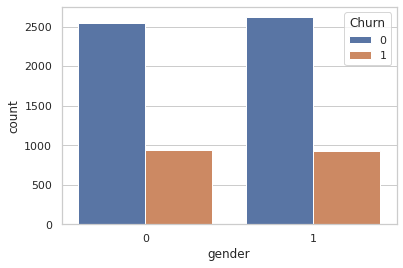

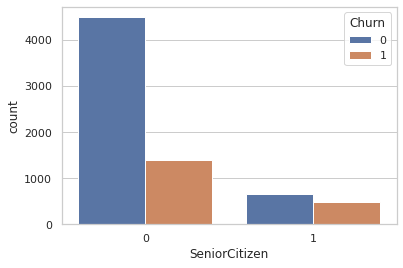

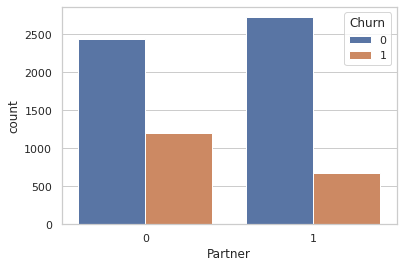

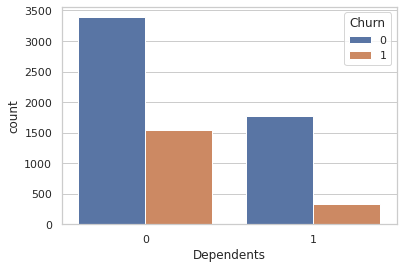

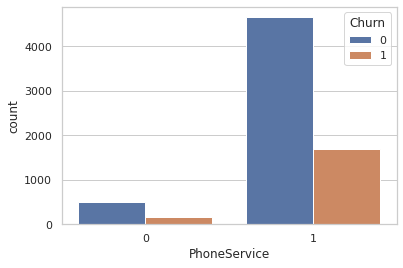

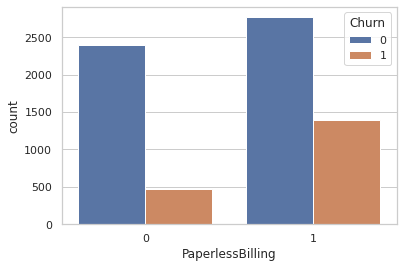

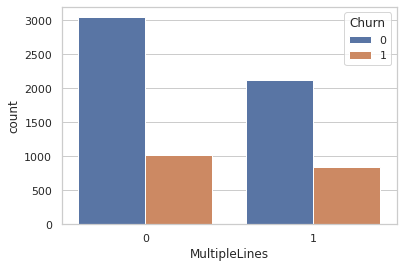

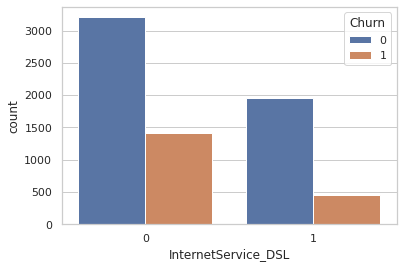

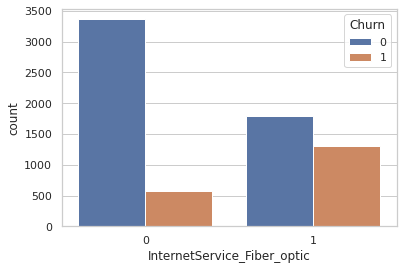

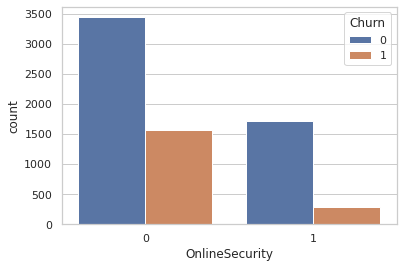

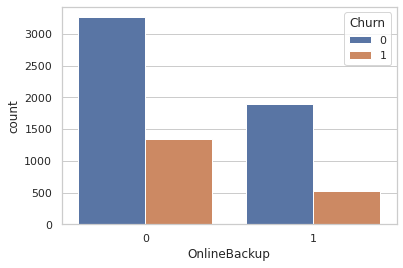

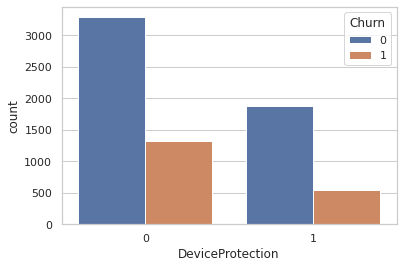

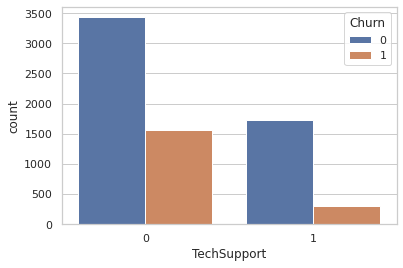

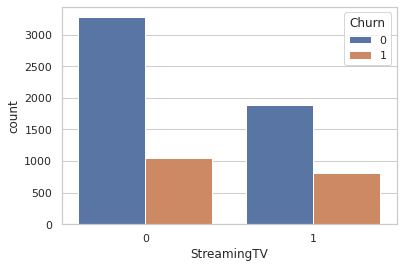

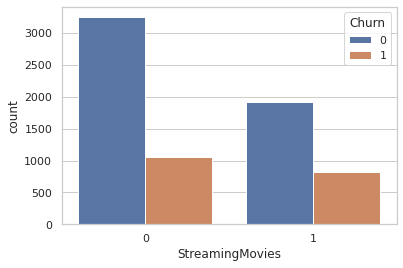

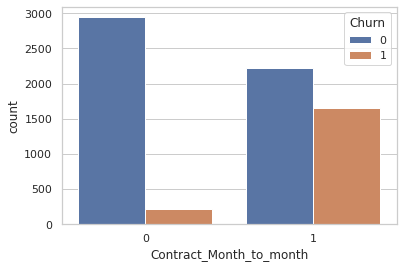

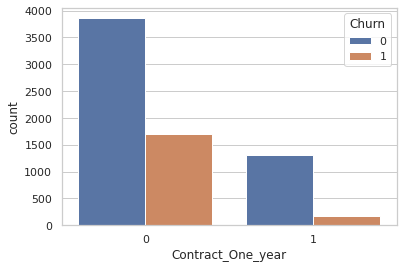

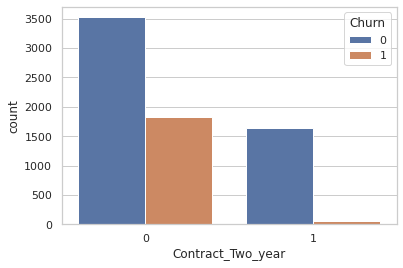

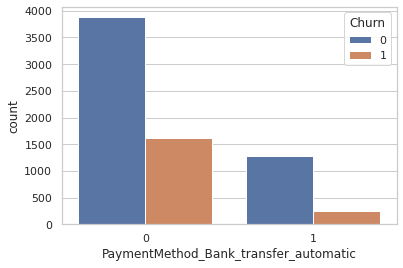

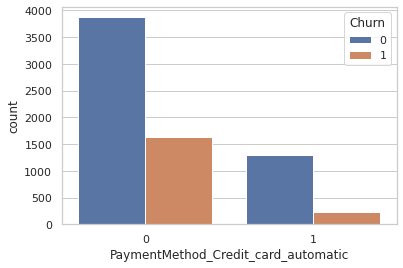

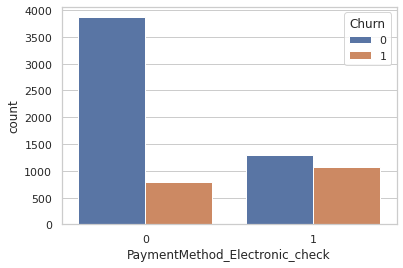

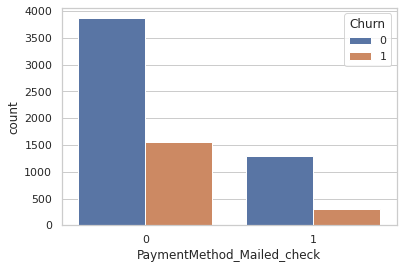

In [19]:
for col in categorical:
    sns.countplot(x=data[col],hue=data.Churn)
    plt.show()

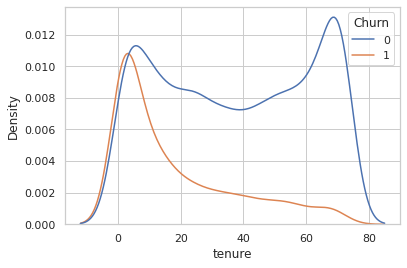

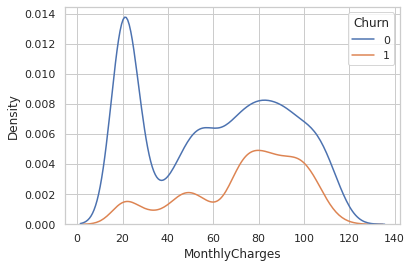

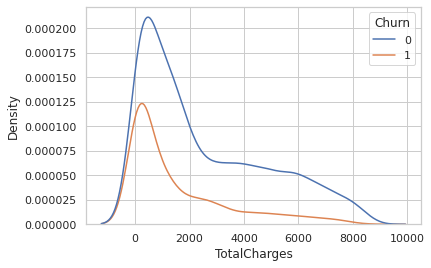

In [20]:
for i in continuous:
    sns.kdeplot(data=data, x=i, hue='Churn')
    plt.show()

In [21]:
# разница LV от типа оплаты
mtm = data[data['Contract_Month_to_month'] == 1].tenure.describe().to_frame()
mtm.columns=['mtm']
mtm = mtm.T

coy = data[data['Contract_One_year'] == 1].tenure.describe().to_frame()
coy.columns=['coy']
coy = coy.T

cty = data[data['Contract_Two_year'] == 1].tenure.describe().to_frame()
cty.columns=['cty']
cty = cty.T

all_ = data.tenure.describe().to_frame()
all_.columns=['all_']
all_ = all_.T

pd.concat([mtm, coy, cty, all_])

,count,mean,std,min,25%,50%,75%,max
mtm,3875.0,18.036645,17.689054,1.0,3.0,12.0,29.0,72.0
coy,1472.0,42.073370,19.010750,1.0,27.0,44.0,58.0,72.0
cty,1685.0,57.071810,17.729130,1.0,48.0,64.0,71.0,72.0
all_,7032.0,32.421786,24.545260,1.0,9.0,29.0,55.0,72.0


In [22]:
# найдем отличия в показателях у senior пользователей
senior_churn = round(data[(data.SeniorCitizen == 1) & (data.Churn == 1)].mean().to_frame(), 2)
senior_churn.columns=['senior_churn']
senior_churn = senior_churn.T
senior_churn

senior_no_churn = round(data[(data.SeniorCitizen == 1) & (data.Churn == 0)].mean().to_frame(), 2)
senior_no_churn.columns=['senior_no_churn']
senior_no_churn = senior_no_churn.T


all_ = round(data.mean().to_frame(), 2)
all_.columns=['all_']
all_ = all_.T


senior = pd.concat([senior_churn, senior_no_churn, all_]).T
senior['diff'] = round(senior['senior_churn'] / senior['senior_no_churn'], 2)
senior.sort_values('diff', ascending=False)

,senior_churn,senior_no_churn,all_,diff
Churn,1.00,0.00,0.27,inf
Contract_Month_to_month,0.93,0.55,0.55,1.69
PaymentMethod_Electronic_check,0.67,0.42,0.34,1.60
InternetService_Fiber_optic,0.83,0.66,0.44,1.26
PaperlessBilling,0.84,0.72,0.59,1.17
PaymentMethod_Mailed_check,0.09,0.08,0.23,1.12
MultipleLines,0.59,0.58,0.42,1.02
MonthlyCharges,80.71,79.18,64.80,1.02
SeniorCitizen,1.00,1.00,0.16,1.00
PhoneService,0.91,0.91,0.90,1.00


## Вывод
### Увеличивает отток:
PaymentMethod_Electronic_check - оплата электронным чеком оказалась самым значимым различием в два раза чаще пользовались этой услугой те кто оказались в оттоке, стоит обратить внимание на удобство системы оплаты для пользователей

Contract_Month_to_month - высокий отток для тех кто оплачивал ежемесячно. Так как более 25% не новые пользователи которые попробоали месячную услугу - отток вероятно определяется они нашли более привлекательное предложение

InternetService_Fiber_optic - большая доля оттока у тех кто предпочитал оптоволоконную связь, возможно стоит проконтролировать качество связи или сравнить с ценовым предложением за подобные услуги компаний конкурентов, возможно в предложении наличие этой услуги переоценено для пользователя

SeniorCitizen - основные отличия отказавшихся пожилых людей от не отказавшихся это то что они пользовались Contract_Month-to-month, PaymentMethod_Electronic_check, InternetService_Fiber_optic. Возможно наблюдалось навязывание ненужных услуг оптоволоконной связи, или неудобство оплаты системой PaymentMethod_Electronic_check.  
Также стоит обратить внимание на то что удерживает от оттока: Contract_One_year и Contract_One_year, подписка на TechSupport и OnlineSecurity, а также оплата через PaymentMethod_Bank_transfer_automatic.  

PaperlessBilling - стоит выяснить отношение пользователей к бумажным чекам за услуги, как они реагируют на их наличие

MonthlyCharges - определённо в зоне риска оттока пользователи с месячной оплатой выше среднего, среди пользователей из оттока средний чек выше на 15%. Стоит посчитать что дешевле - терять пользователей но на вырученные от переплаты средства привлекать новых, либо предложить скидку постоянным пользователям с высоким средним чеком

StreamingMovies, StreamingTV - удивительно но подписка на эти сервисы увеличивает риск оттока на 15%
 
### Также стоит обратить внимание на то что удерживает пользователей
Это также можно использовать это в качестве аргументов для апривлечения новых:
InternetService_DSL увеличивает удержание на 29%  
PaymentMethod_automatic увеличивает удержание на 40%  
TechSupport увеличивает удержание на 39%  
OnlineSecurity увеличивает удержание на 45%  
Contract_One_year или Contract_Two_year увеличивает удержание на 58% и 89% соответственно  

<hr>

## Обучение моделей
Для предсказания оттока обучим модели логистической регрессии (LogisticRegression) и случайного леса (RandomForestClassifier), а также протестируем стандартизацию данных (StandardScaler) для улучшения показателей

In [75]:
# создаёт датасет с переменными выше указанного квантиля минимального порога корреляции
def get_optimal_corr_dataset(data, quantile):
    # посчитаем коэффециент корреляции Пирсона между переменными
    corr_df = data.corr()
    correlation = abs(corr_df['Churn'])
    # определяем оптимальный порог значимости корреляции
    threshold = correlation.quantile(quantile)
    # отбираем только подходящие переменные
    filtered_columns_list = correlation[correlation > threshold].keys().tolist()
    return data[filtered_columns_list]

In [200]:
# подбираем датасет с оптимальным порогом корреляции
data_corr = get_optimal_corr_dataset(data, 0.0)

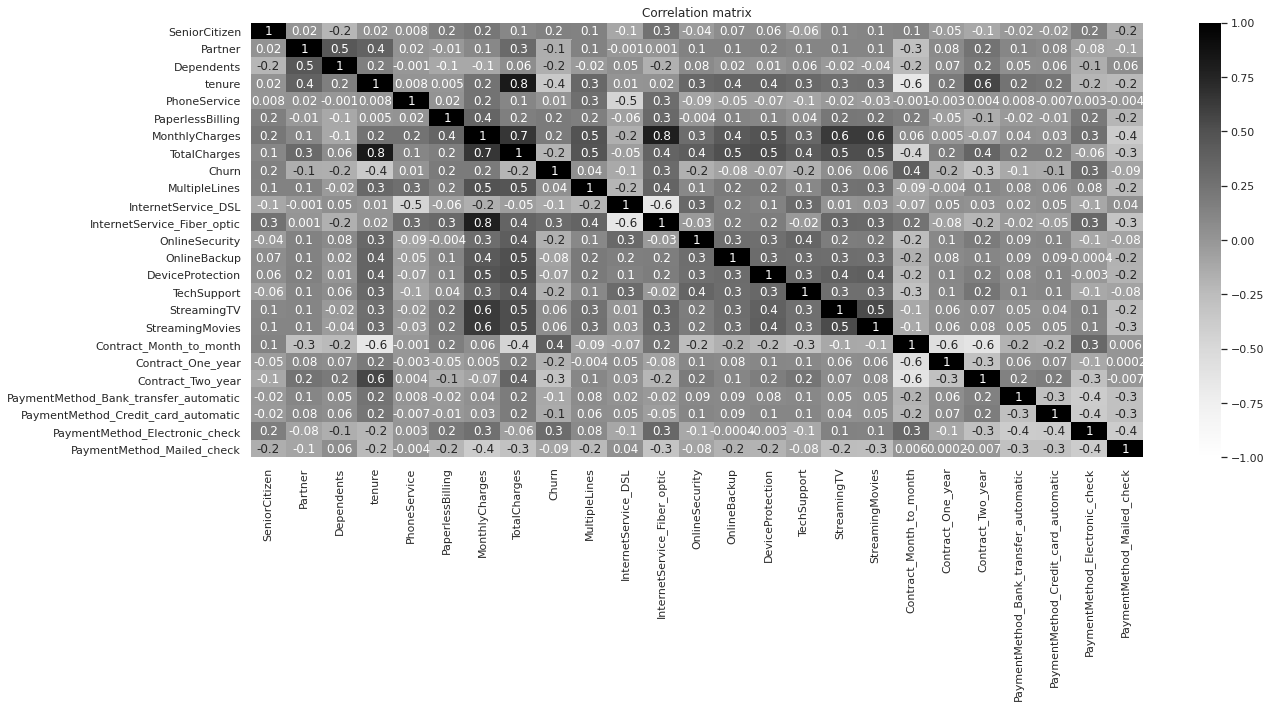

In [201]:
# посмотрим есть ли мультиколлинеарные признаки
plt.figure(figsize=(20, 8))
plt.title('Correlation matrix')
sns.heatmap(data_corr.corr(), annot = True, fmt='.1g', vmin=-1, vmax=1, cmap='Greys')
plt.show()

In [202]:
# определяем признаки 
x = data_corr.drop('Churn', axis=1)
y = data_corr['Churn']

# разделим значения признаков на группы обучения и теста
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.8, random_state=0, stratify=y)

In [203]:
#Зададим функцию проверки метрик
def score(name, test, predict):
    accuracy = accuracy_score(test, predict)
    precision = precision_score(test, predict)
    recall = recall_score(test, predict)
    return[name, round(accuracy, 2), round(precision, 2), round(recall, 2)]

In [204]:
# стандартизируем данные 
scaler = StandardScaler()
scaler.fit(x_train)

x_train_SS = scaler.transform(x_train)
x_test_SS = scaler.transform(x_test)

In [205]:
# обучаем модель LogisticRegression
model_LR = LogisticRegression(solver='liblinear')
model_LR.fit(x_train, y_train)

LogisticRegression(solver='liblinear')

In [206]:
# обучаем модель RandomForestClassifier
model_RF = RandomForestClassifier(n_estimators=100, random_state=0) 
model_RF.fit(x_train, y_train)

RandomForestClassifier(random_state=0)

In [207]:
# результаты тестов
data_result = []

In [208]:
# считаем метрики для LogisticRegression
pred_LR = model_LR.predict(x_test)
proba_LR = model_LR.predict_proba(x_test)[:,1]

data_result.append(score('LogisticRegression:', y_test, pred_LR))

In [209]:
# считаем метрики для StandardScaler LogisticRegression
model_LR.fit(x_train_SS, y_train)
y_pred_SS= model_LR.predict(x_test_SS)

data_result.append(score('StandardScaler LogisticRegression:', y_test, y_pred_SS))

In [210]:
# считаем метрики для RandomForestClassifier
pred_RF = model_RF.predict(x_test)
proba_RF = model_RF.predict_proba(x_test)[:,1] 

data_result.append(score('RandomForestClassifier:', y_test, pred_RF))

In [211]:
# считаем метрики для StandardScaler RandomForestClassifier
model_RF.fit(x_train_SS, y_train)
pred_RF_SS = model_RF.predict(x_test_SS)

data_result.append(score('StandardScaler RandomForestClassifier:', y_test, pred_RF_SS))

In [213]:
# сравним результаты
pd.DataFrame(data_result, columns=['method', 'accuracy', 'precision', 'recall'])

,method,accuracy,precision,recall
0,LogisticRegression:,0.81,0.68,0.52
1,StandardScaler LogisticRegression:,0.80,0.66,0.54
2,RandomForestClassifier:,0.78,0.61,0.49
3,StandardScaler RandomForestClassifier:,0.78,0.61,0.49


In [215]:
# считаем доли
c1 = data[data.Churn == 1].Churn.count()
c2 = data[data.Churn == 0].Churn.count()

print('доля churn', round(c1 / (c1 + c2), 2))

доля churn 0.27


## Вывод:

Показатель правильных ответов (accuracy) не корректный, так как доли при сравнении не одинаковые (доля churn 27%)

Показатель точности (precision) для данной задачи более значимая метрика, так как каждый клиент, которого будут удерживать от оттока, будет стоить денег. Он лучше у LogisticRegression

Стандартизация улучшила показатель по (recall) LogisticRegression

Эксперименты с фильтрацией переменных выше допустимого порога корреляции для достижения большего эффекта предсказания не показали значимых результатов.

Лучшая модель для определения оттока пользователей: StandardScaler LogisticRegression

<hr>

# Кластеризация пользователей
Нам необходимо разделить группы на несколько кластеров для определения значимых различий прокси переменных

In [216]:
# обучим модель StandardScaler для построения dendrogram
scaler = StandardScaler() 
model_SS_tr = scaler.fit_transform(x) 

linked = linkage(model_SS_tr, method='ward')

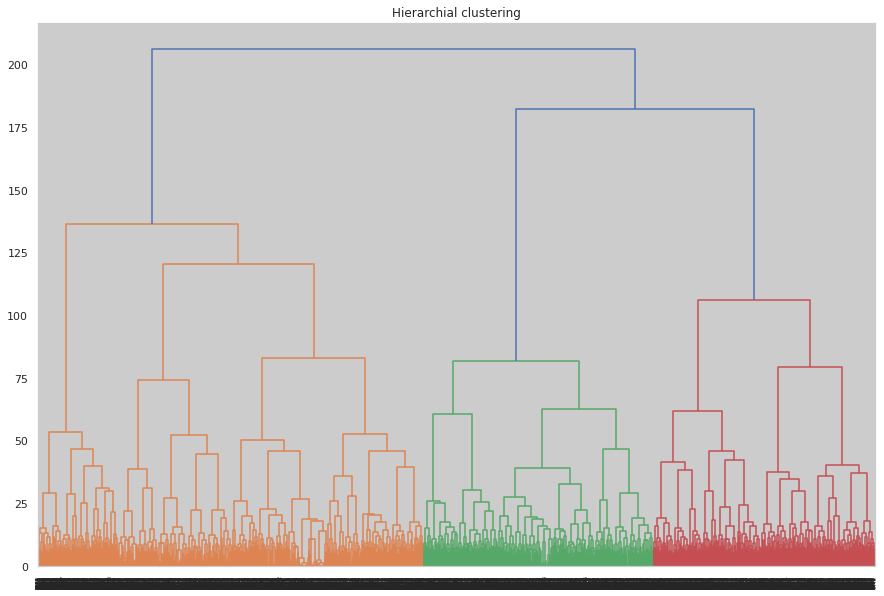

In [214]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering')
plt.show()

In [223]:
# подбор оптимальной кластеризации
def get_optimal_cluster(model, clusters):
    data = []
    for cluster in clusters:
        km = KMeans(n_clusters=cluster, random_state=100) 
        labels = km.fit_predict(model)
        score = silhouette_score(model, labels)
        data.append([cluster, score, labels])
    df = pd.DataFrame(data, columns=['cluster', 'score', 'labels'])
    display(df[['cluster', 'score']].sort_values('score', ascending=False))
    result = df.iloc[df.score.idxmax()]
    return {'cluster': result.cluster, 'score': result.score, 'labels': result.labels}

In [225]:
# получаем оптимальное количество кластеров
result = get_optimal_cluster(model_SS_tr, [i for i in range(2, 9)])
labels = result['labels']

,cluster,score
0,2,0.167388
2,4,0.147365
1,3,0.141379
3,5,0.134758
4,6,0.132510
6,8,0.129005
5,7,0.124899


In [220]:
# мы выберем 4 кластера, кластеризуем
clusters = 4
km = KMeans(n_clusters=clusters, random_state=100)
labels = km.fit_predict(model_SS_tr)
print('Silhouette_score for {} clusters: {:.2f}'.format(clusters, silhouette_score(model_SS_tr, labels)))

Silhouette_score for 4 clusters: 0.15


In [ ]:
# добавляем значения кластера в данные
data['cluster'] = labels

# показатель оттока для кластеров
data.groupby('cluster').mean().Churn

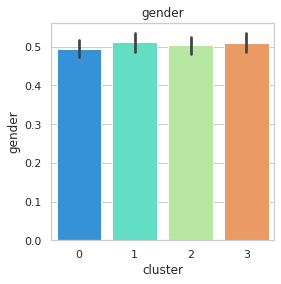

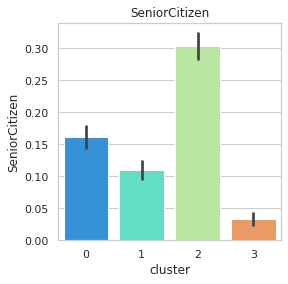

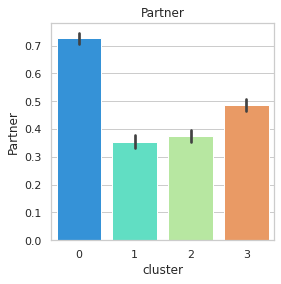

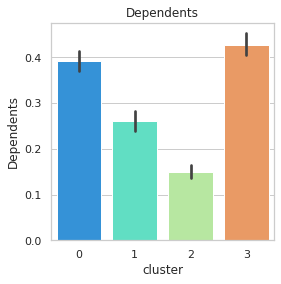

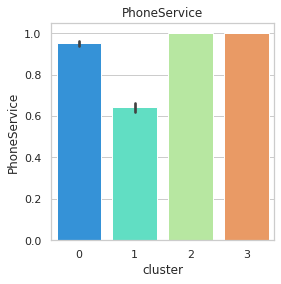

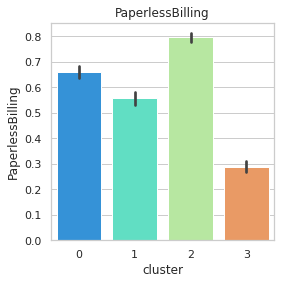

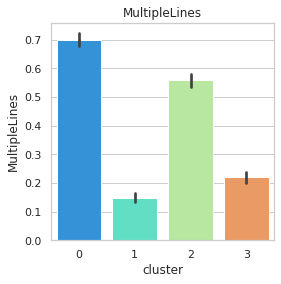

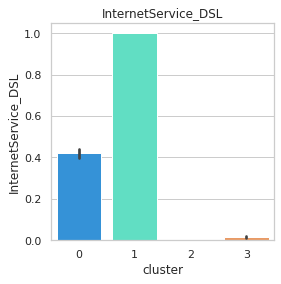

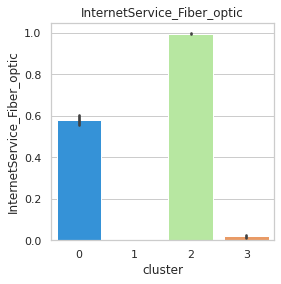

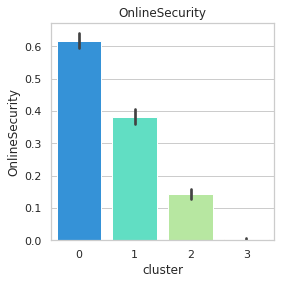

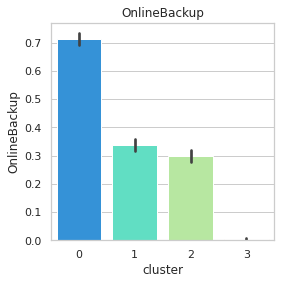

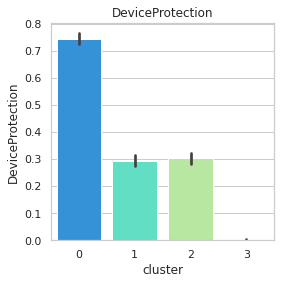

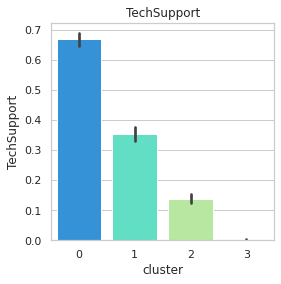

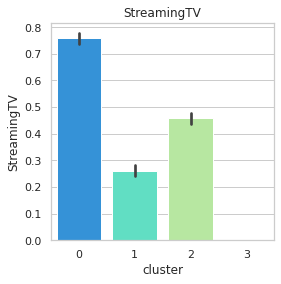

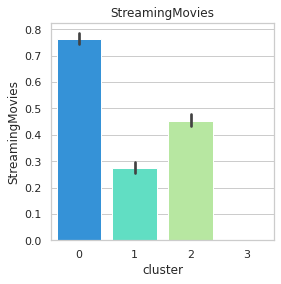

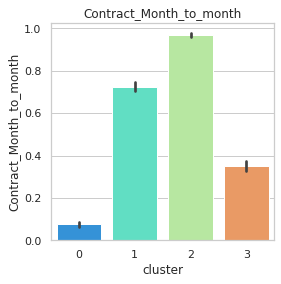

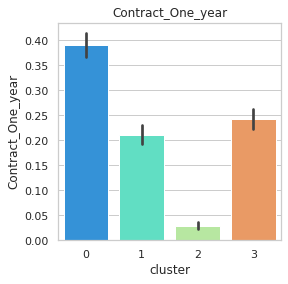

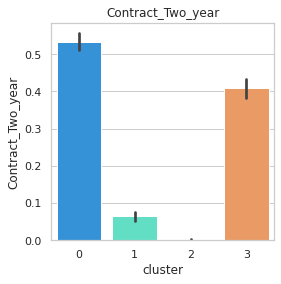

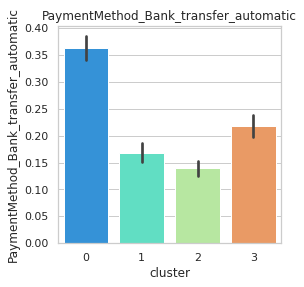

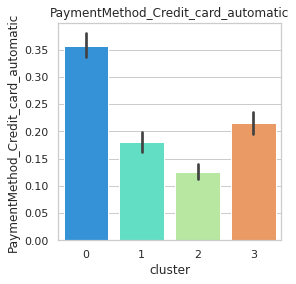

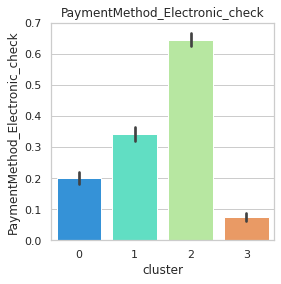

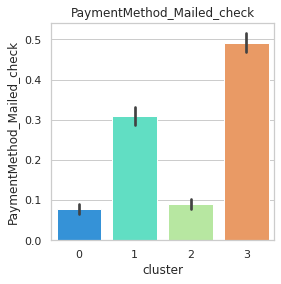

In [263]:
for i in categorical:
    sns.barplot(x='cluster', y=i, data=data, palette='rainbow')
    plt.title(el)
    plt.show()

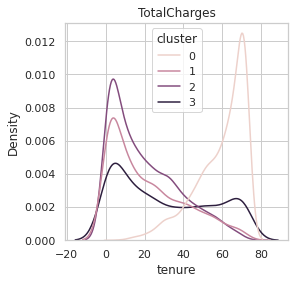

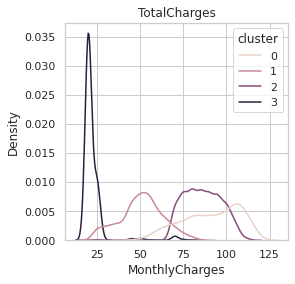

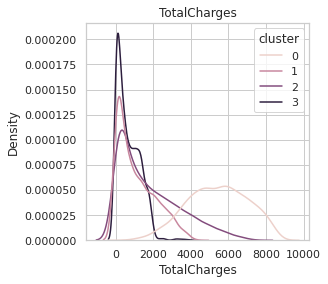

In [267]:
for i in continuous:
    sns.kdeplot(data=data, x=i, hue='cluster')
    plt.title(el)
    plt.show()

## Вывод
Показатели различия кластеров:  
Dependents - чем больше показатель тем меньше шансов оттока  
PaperlessBilling - чем меньше показатель тем меньше шансов оттока  
PaymentMethod_Electronic_check - чем меньше показатель тем меньше шансов оттока  

### кластер 0 (самый высокии уровень оттока)
SeniorCitizen - больше всего людей пожилого возраста  
Contract_Month_to_month - наличие показателя приводит к оттоку  
MonthlyCharges, TotalCharges - высокая стоимость услуг приводит к оттоку

### кластер 1
Contract_Month_to_month - наличие показателя приводит к оттоку  

### кластер 2
Partner - высокий показатель наличия партнера  
Contract_One_year, Contract_Two_year, PaymentMethod_Credit_card_automatic, PaymentMethod_Bank_transfer_automatic - наличие показателя приводит к удержанию

### кластер 3 (самый низкий уровень оттока)
Partner - высокий показатель наличия партнера  
Contract_One_year, Contract_Two_year, PaymentMethod_Credit_card_automatic, PaymentMethod_Bank_transfer_automatic - наличие показателя приводит к удержанию